### business_ML3: Прогноз сердечно-сосудистых нарушений

Датасет:

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [ ]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Подготовка данных

In [ ]:
df = pd.read_csv('train_case2.csv', sep=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', axis=1), 
                                                    df['cardio'], random_state=197)

### Feature Selection

- gender, cholesterol ==> OHE-кодирование
- age, height, weight, ap_hi, ap_lo ==> StandardScaler

In [ ]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [ ]:
cat_transformers

[('gender', Pipeline(steps=[('selector', ColumnSelector(key='gender')),
                  ('ohe', OHEEncoder(key='gender'))])),
 ('cholesterol',
  Pipeline(steps=[('selector', ColumnSelector(key='cholesterol')),
                  ('ohe', OHEEncoder(key='cholesterol'))]))]

### Объединение трансформеров с помощью FeatureUnion

In [ ]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[ 0.00888122, -1.75001304,  0.12595234, ...,  0.        ,
         0.        ,  0.        ],
       [-1.40047829,  1.29638418,  0.26446066, ...,  0.        ,
         0.        ,  0.        ],
       [-0.70714473,  0.07782529, -0.35882677, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.92792302, -0.65331004, -0.08181014, ...,  0.        ,
         0.        ,  0.        ],
       [-0.19251374,  0.07782529, -0.35882677, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.94332143, -0.04403059,  0.81849392, ...,  0.        ,
         0.        ,  1.        ]])

### Классификатор и кросс-валидация

In [ ]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import cross_val_score

In [ ]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state = 197)),
])

lr_scores = cross_val_score(classifier, X_train, y_train, cv=12, scoring='roc_auc')
lr_score = np.mean(lr_scores)
lr_score_std = np.std(lr_scores)
print('CV score is {}'.format(round(lr_score, 4)))

classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7821


### precision/recall/f_score и Roc_curve

In [ ]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix

In [ ]:
b=2/3
lr_precision, lr_recall, lr_thresholds = precision_recall_curve(y_test.values, y_score)
lr_fscore = (1+b**2)*(lr_precision * lr_recall) / (b**2*lr_precision + lr_recall)

ix = np.argmax(lr_fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (lr_thresholds[ix], 
                                                                        lr_fscore[ix],
                                                                        lr_precision[ix],
                                                                        lr_recall[ix]))

Best Threshold=0.491808, F-Score=0.722, Precision=0.736, Recall=0.693


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

Confusion matrix, without normalization
[[6620 2169]
 [2672 6039]]


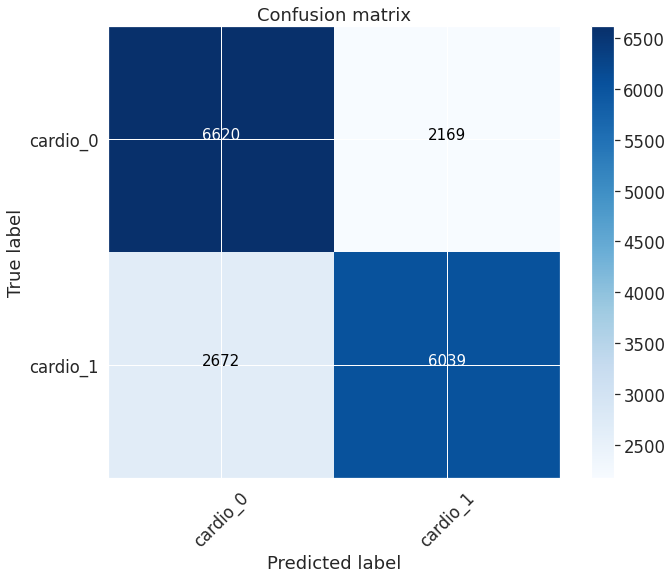

In [ ]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>lr_thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [ ]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.693261393640225, 0.2467857549209239, 0.7532142450790761)

False Positive Rate: ~ 0.25.

Четверть пациентов получат метку 1 при том, что они на самом деле здоровы

### Дополнительно

Обучил несколько разных моделей на наборе данных ССЗ: логрег, бустинг, лес. Сравнил по метрикам.

In [ ]:
# !pip install catboost

In [ ]:
from sklearn.ensemble import RandomForestClassifier as rfc

from catboost import CatBoostClassifier as ctb

from sklearn.neighbors import KNeighborsClassifier as knn

In [ ]:
def build_and_train_classifier(algorithm_name, b=1):

  algorithm = Pipeline([
    ('features', feats),
    ('classifier', algorithm_name() ) ])

  cv_scores = cross_val_score(algorithm, X_train, y_train, cv=12, scoring='roc_auc')
  print(f'{algorithm_name}: cv_score is { (round( np.mean(cv_scores), 4) ) }')

  algorithm.fit(X_train, y_train)
  y_score = algorithm.predict_proba(X_test)[:, 1]

  b=1.0
  precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
  fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)

  ix = np.argmax(fscore)
  print('{algorithm_name}: Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))  
  

  return cv_scores, precision, recall, fscore

In [ ]:
rfc_scores, rfc_precision, rfc_recall, rfc_fscore = build_and_train_classifier(rfc, 0.7)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>: cv_score is 0.7719
{algorithm_name}: Best Threshold=0.370000, F-Score=0.724, Precision=0.652, Recall=0.814


In [ ]:
knn_scores, knn_precision, knn_recall, knn_fscore = build_and_train_classifier(knn)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>: cv_score is 0.6884
{algorithm_name}: Best Threshold=0.400000, F-Score=0.686, Precision=0.586, Recall=0.826


In [ ]:
ctb_scores, ctb_precision, ctb_recall, ctb_fscore = build_and_train_classifier(ctb)

In [ ]:
my_dict = {'model': ['LogRes', 'RFC', 'KNN', 'CatBoost'],
           'cv_scores': [np.mean(lr_scores), np.mean(rfc_scores), np.mean(knn_scores), np.mean(ctb_scores)],
           'precision': [np.mean(lr_precision), np.mean(rfc_precision), np.mean(knn_precision), np.mean(ctb_precision)],
           'recall': [np.mean(lr_recall), np.mean(rfc_recall), np.mean(knn_recall), np.mean(ctb_recall)],
           'F-score': [np.mean(lr_fscore), np.mean(rfc_fscore), np.mean(knn_fscore), np.mean(ctb_fscore)]}

models_df = pd.DataFrame(my_dict)

In [ ]:
models_df

,model,cv_scores,precision,recall,F-score
0,LogRes,0.782059,0.705933,0.643018,0.607058
1,RFC,0.771858,0.685333,0.690218,0.625566
2,KNN,0.688432,0.678047,0.558981,0.483837
3,CatBoost,0.800704,0.723316,0.652787,0.611451


KNN очевидно к этой задаче не подходит.

Остальные модели примерно похожи. 

На кроссвалидации выигрывает Catboost. 

А вот по метрике recall здесь лучше Случайный лес (максимизировать полноту нужно в случае кейса по прогнозу заболеваний, как в этом: лучше допустить ложно положительный прогноз, чем пропустить пациента с реальной патологией).

Поэтому в дальнейшей работе нужно уже улучшать RandomForest.